# Video: Implementing Text Classifiers from Language Model Embeddings

The internal states of language models can be used to summarize and extract information from the input text.
This video shows how to implement text classifiers based on language model embeddings and simple linear regression.

Script: (faculty on screen)
* Language models have been used for text classification and other analysis since before the current popular chat interfaces.
* After processing input text, an embedding vector is extracted from the language model's internal state.
* A small and fast classifier can be trained with those embedding vectors as input.
* Typically, these classifiers are just linear models, so they are easy to train and do not need a large amount of data.
* Most language model API providers provide an embedding interface to convert text documents to vectors.
* In this video, I will show you how to use Google's Gemini API to generate text embedding vectors, and use them to build quick classifiers.

In [ ]:
%pip install -q google-genai

In [ ]:
import google.genai as genai
from google.genai import types
from google.colab import userdata
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.linear_model

In [ ]:
recipes = pd.read_csv("https://raw.githubusercontent.com/bu-cds-omds/dx704-examples/refs/heads/main/data/recipes.tsv.gz", sep="\t")
recipes = recipes.set_index("recipe_slug")
recipes = recipes[:2000]

In [ ]:
recipe_tags = pd.read_csv("https://raw.githubusercontent.com/bu-cds-omds/dx704-examples/refs/heads/main/data/recipe-tags.tsv.gz", sep="\t")
recipe_tags = recipe_tags.query("recipe_slug in @recipes.index")

Script:
* I loaded the recipes data from Bacon Powered Recipes, and truncated it to 2000 recipes for this demo.
* This video will have a number of long code cells, so I've already entered all the code, and will explain it as we go.

In [ ]:
client = genai.Client(api_key=userdata.get('GEMINI_API_KEY'))

In [ ]:
embedding_model_name = 'gemini-embedding-001'

Script:
* We will be using Google's genai library and their gemini-embedding-001 model.
* At this time, that is the only embedding that they offer.

In [ ]:
recipe_embeddings = {}

Script:
* This dictionary will be used to story the document vectors for the recipes.
* I will store the full vectors of 3072 dimensions returned by the API.

In [ ]:
def save_recipe_embedding(recipe_tuple):
    recipe_slug = recipe_tuple.Index
    if recipe_slug in recipe_embeddings:
        return

    response = client.models.embed_content(model=embedding_model_name,
                                           contents=recipe_tuple.recipe_introduction,
                                           config=types.EmbedContentConfig(task_type="CLASSIFICATION"))
    recipe_embeddings[recipe_slug] = response.embeddings[0].values

for r in recipes.itertuples():
    save_recipe_embedding(r)
    break

for recipe_slug, recipe_embedding in recipe_embeddings.items():
    print(recipe_slug, len(recipe_embedding), recipe_embedding)
    break

spiced-pear-and-walnut-salad 3072 [-8.8935696e-05, -0.0052569485, 0.021320296, -0.055818524, 0.008810814, -0.0010502733, 0.018125517, 0.01533589, 0.0061770785, 0.0050520315, 0.010656772, -0.01468967, 0.014323305, 0.00034809267, 0.11392061, 0.0019770567, 0.016609993, 0.0036741872, 0.03261456, -0.032394785, -0.0043965736, -0.01654749, 0.026461273, 0.007860871, -0.015375456, 0.020321406, 0.031169819, -0.024172125, 0.007130429, 0.029999541, 0.002666725, 0.026646955, 0.002270871, 0.01127252, 0.027603809, -0.008694265, 0.019195052, 0.005086065, 0.00018730883, -0.005520916, -0.025684232, 0.019288264, -0.012133019, 0.008795306, 0.0009792123, -0.005554449, 0.031930048, 0.022096504, -0.0066074147, 0.012118121, 0.03345638, -0.0071705845, 0.0053820787, -0.17817014, -0.0042005265, 0.0036484066, -0.023548838, -0.03679682, -0.007919467, -0.010554509, 0.032974925, 0.02825576, 0.027631301, 0.0022054843, -0.023892773, -0.023755856, -0.02086687, -0.0016309392, 0.0034277125, 0.016492171, -0.02840699, -0.0

Script:
* This function save_recipe_embedding takes in a recipe row and calls the API to get an embedding optimized for classification.
* It uses the previous dictionary as a cache to avoid repeating API calls.
* Google has options for embeddings optimized for different purposes such as document search.
* I originally tested this code without specifying the classification type and did not see a material difference in behavior.
* After the function definition, I ran it on the first recipe and printed out its slug, vector length of 3072, and the vector itself.

In [ ]:
for r in recipes.itertuples():
    save_recipe_embedding(r)

Script:
* This loop just calls the API for all the recipes.
* I ran it before recording.
* Otherwise, it would have taken 10 minutes.
* Before we start with classification, let's look at the tags for classification candidates.

In [ ]:
recipe_tags.groupby("recipe_tag").count().sort_values(by="recipe_slug", ascending=False).head(10)

,recipe_slug
recipe_tag,
dessert,223
comfortfood,164
healthy,150
vegetarian,149
breakfast,125
savory,94
sweet,92
appetizer,89
cheese,85


Script:
* I will make classification models for the first 3 tags there, dessert, comfort food and healthy.

In [ ]:
np.random.seed(704)
train_recipes = recipes.sample(frac=0.8)
test_recipes = recipes.drop(train_recipes.index)

Script:
* I'll split the recipes into train and test sets with 80% for training and 20% for testing.

In [ ]:
train_features = np.asarray([recipe_embeddings[recipe_slug] for recipe_slug in train_recipes.index])
test_features = np.asarray([recipe_embeddings[recipe_slug] for recipe_slug in test_recipes.index])

train_features.shape, test_features.shape

((1600, 3072), (400, 3072))

Script:
* Here are the feature vectors for the train and test data.
* We will test using smaller sets of columns since the embedding vectors have more dimensions than rows of training data.

In [ ]:
def make_target(recipe_tag):
    target_slugs = recipe_tags.query('recipe_tag == @recipe_tag')[["recipe_slug"]].set_index("recipe_slug")
    target = np.array([1 if recipe_slug in target_slugs.index else 0 for recipe_slug in recipes.index])
    target = pd.Series(target, recipes.index)

    train_target = target.loc[target.index.isin(train_recipes.index)]
    test_target = target.loc[target.index.isin(test_recipes.index)]

    return train_target, test_target

make_target("dessert")

(recipe_slug
 spiced-pear-and-walnut-salad          0
 peach-clafoutis                       1
 plum-clafoutis                        1
 pear                                  1
 pear-and-gingerbread-trifle           1
                                      ..
 antipasto-platter                     0
 apple-crisp                           1
 apple-crumble                         1
 chocolate-peanut-butter-cheesecake    1
 maple-brown-sugar-oatmeal             0
 Length: 800, dtype: int64,
 recipe_slug
 roasted-pear-and-butternut-squash-soup    0
 doritos-loaded-baked-potatoes             0
 bacon-and-egg-grilled-cheese-sandwich     0
 almond-croissants                         0
 artichoke-pasta                           0
                                          ..
 garlic-and-soy-glazed-grilled-salmon      0
 almond-joy-fudge                          1
 cinnamon-rolls                            1
 almond-chip-cookies                       1
 artichoke-and-spinach-pizza               0


Script:
* This function extracts the train and test targets to match the feature data.

In [ ]:
def train_embedding_model(recipe_tag, embedding_width=64):
    train_X = train_features[:,:embedding_width]
    (train_Y, test_Y) = make_target(recipe_tag)

    model = sklearn.linear_model.LinearRegression()
    model.fit(train_X, train_Y)

    test_X = test_features[:,:embedding_width]

    predictions = model.predict(test_X)
    predictions = predictions >= 0.5
    return (test_Y == predictions).mean()

train_embedding_model("dessert")

np.float64(0.8025)

Script:
* This function trains a linear model for a given recipe tag with a configurable embedding width.
* That will let us experiment with different embedding widths.
* The Gemini embeddings use a Matroschka embedding design, named after the nested Russian dolls, that concentrates the information in the earlier values of the vector making truncated versions more useful.
* Modeling dessert with an embedding width of 64 gave an 80% accuracy.
* That is not the best that can be done on this data set, but we got that with a small generic vector.

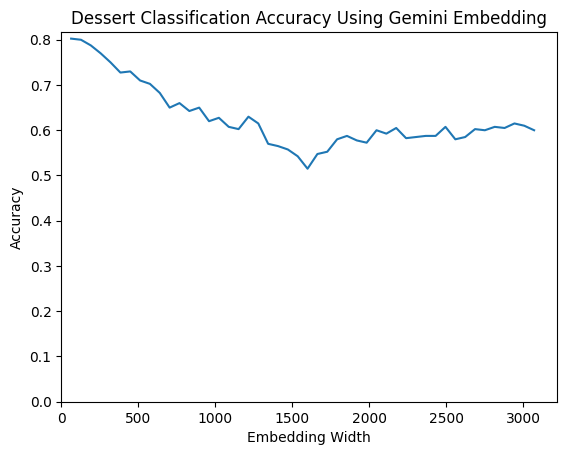

In [ ]:
def plot_classification_accuracy(recipe_tag):
    xs = []
    ys = []
    for x in range(64, 3072+1, 64):
        xs.append(x)
        ys.append(train_embedding_model(recipe_tag, embedding_width=x))

    plt.plot(xs, ys)
    plt.title(f"{recipe_tag.replace('_', ' ').title()} Classification Accuracy Using Gemini Embedding")
    plt.xlabel("Embedding Width")
    plt.xlim(0)
    plt.ylabel("Accuracy")
    plt.ylim(0)
    plt.show()

plot_classification_accuracy("dessert")

Script:
* The next function tests out modeling a tag on a number of embedding widths.
* The shortest vectors seem to do the best here with about 80% accuracy.
* I did separately test shorter vectors with similar results.
* Increasing the vector length decreases the performance, possibly from overfitting this small data set, and then levels out around 60%.


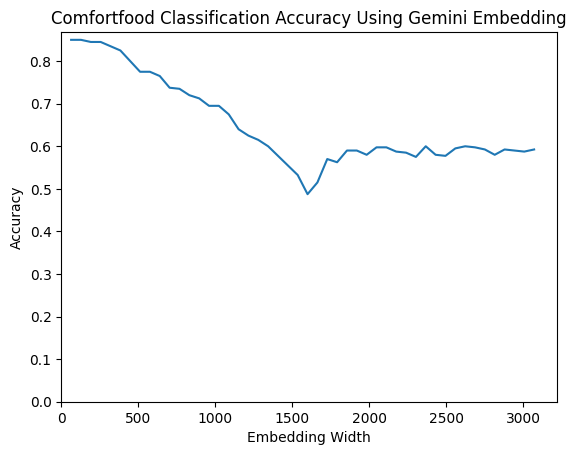

In [ ]:
plot_classification_accuracy("comfortfood")

Script:
* Building a classifier for comfort food gave a similar pattern starting high around 85%, declining, and then improving a bit before level out.

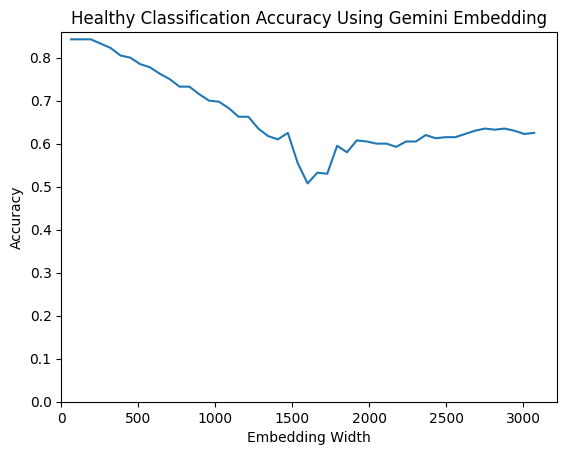

In [ ]:
plot_classification_accuracy("healthy")

Script:
* The same general trend happened with healthy food.
* It is interesting that the shapes of these curves are so similar.
* The specific shape is probably a mix of the Matroschka embedding design optimizing short vectors and overfitting  the relatively small data set.
* The bottom point for these three classifiers is close to 1600 which matches with the training data set size and the common double descent pattern.

Script: (faculty on screen)
* Language model embeddings give an off the shelf way to quickly put together a text classifier.
* Simple classifiers based on these embeddings tend to be near state of the art accuracy with a lot less work to get there.
* These classifiers can be further improved by fine-tuning the whole model, but using a fixed shared embedding space is often more practical.